# Predicting Energy Poverty (SDG 7) Using Satellite Embeddings

This notebook demonstrates how to use Random Forest regression to predict the SDG 7 Index (Affordable and Clean Energy) using 64-dimensional satellite imagery embeddings from Google Earth Engine.

## Objectives
1. Load and merge SDG indices with satellite embeddings
2. Build a Random Forest model with cross-validation
3. Analyze feature importance
4. Evaluate model performance
5. Visualize predictions spatially
6. Compare with SDG 1 (Poverty) prediction patterns

## 1. Setup and Data Loading

In [1]:
# Install required packages (uncomment if needed)
# !pip install pandas numpy scikit-learn matplotlib seaborn geopandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Define repository URL
REPO_URL = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master"

# Load datasets
print("Loading datasets...")
url_names = f"{REPO_URL}/regionNames/regionNames.csv"
url_sdg = f"{REPO_URL}/sdg/sdg.csv"
url_embeddings = f"{REPO_URL}/satelliteEmbeddings/satelliteEmbeddings2017.csv"

df_names = pd.read_csv(url_names)
df_sdg = pd.read_csv(url_sdg)
df_embeddings = pd.read_csv(url_embeddings)

print(f"✓ Loaded {len(df_names)} municipalities")
print(f"✓ Loaded {len(df_sdg.columns)-1} SDG variables")
print(f"✓ Loaded {len(df_embeddings.columns)-1} satellite embedding dimensions")

Loading datasets...
✓ Loaded 339 municipalities
✓ Loaded 16 SDG variables
✓ Loaded 64 satellite embedding dimensions


## 2. Data Preparation

In [4]:
# Merge datasets
df = pd.merge(df_names, df_sdg, on='asdf_id', how='inner')
df = pd.merge(df, df_embeddings, on='asdf_id', how='inner')

print(f"Merged dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df[['mun', 'dep', 'index_sdg7', 'A00', 'A01', 'A02']].head()

Merged dataset shape: (339, 88)

First few rows:


,mun,dep,index_sdg7,A00,A01,A02
0,Esmeralda,Oruro,52.230000,-0.060433,-0.052295,-0.009320
1,Quillacas,Oruro,50.110001,-0.104140,0.013027,-0.063797
2,Pampa Aullagas,Oruro,45.450001,-0.107063,0.021826,-0.036949
3,Llallagua,Potosí,69.360001,-0.130482,-0.044621,-0.114217
4,Caripuyo,Potosí,36.000000,-0.123298,-0.058626,-0.108308


In [5]:
# Check for missing values in target variable
print(f"Missing values in SDG 7 Index: {df['index_sdg7'].isna().sum()}")

# Remove any rows with missing target or features
embedding_cols = [col for col in df.columns if col.startswith('A')]
df_clean = df[['asdf_id', 'mun', 'dep', 'index_sdg7', 'index_sdg1'] + embedding_cols].dropna()

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Number of embedding features: {len(embedding_cols)}")

Missing values in SDG 7 Index: 0
Clean dataset shape: (339, 69)
Number of embedding features: 64


In [6]:
# Prepare features (X) and target (y)
X = df_clean[embedding_cols].values
y = df_clean['index_sdg7'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget variable statistics (SDG 7 - Energy):")
print(f"Mean: {y.mean():.2f}")
print(f"Std: {y.std():.2f}")
print(f"Min: {y.min():.2f}")
print(f"Max: {y.max():.2f}")

Features shape: (339, 64)
Target shape: (339,)

Target variable statistics (SDG 7 - Energy):
Mean: 52.26
Std: 14.91
Min: 24.94
Max: 96.53


## 3. Exploratory Analysis

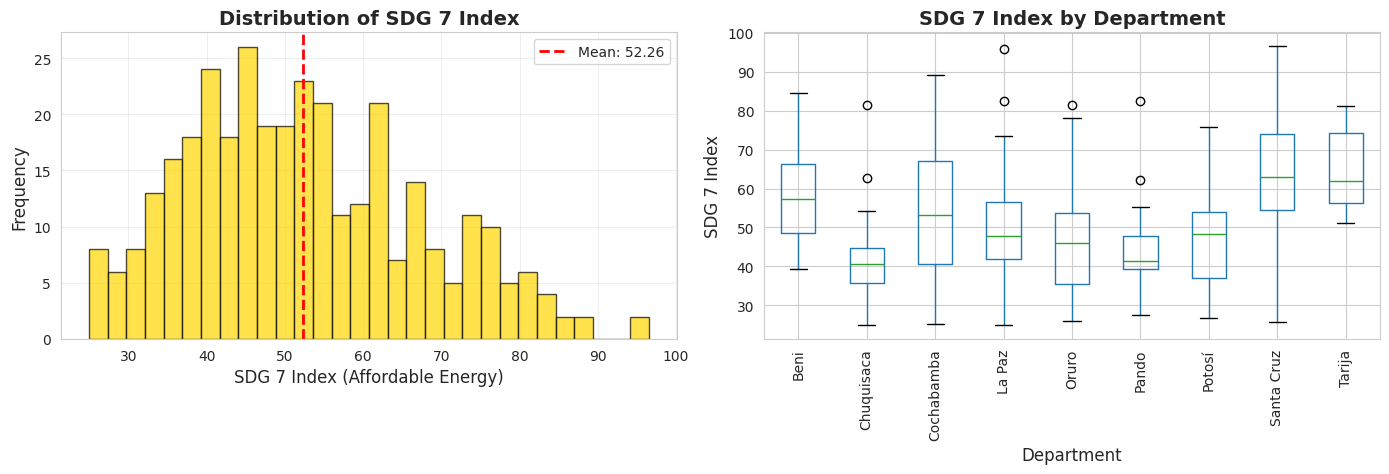

In [7]:
# Distribution of SDG 7 Index
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7, color='gold')
axes[0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y.mean():.2f}')
axes[0].set_xlabel('SDG 7 Index (Affordable Energy)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of SDG 7 Index', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot by department
df_clean.boxplot(column='index_sdg7', by='dep', ax=axes[1], rot=90)
axes[1].set_xlabel('Department', fontsize=12)
axes[1].set_ylabel('SDG 7 Index', fontsize=12)
axes[1].set_title('SDG 7 Index by Department', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

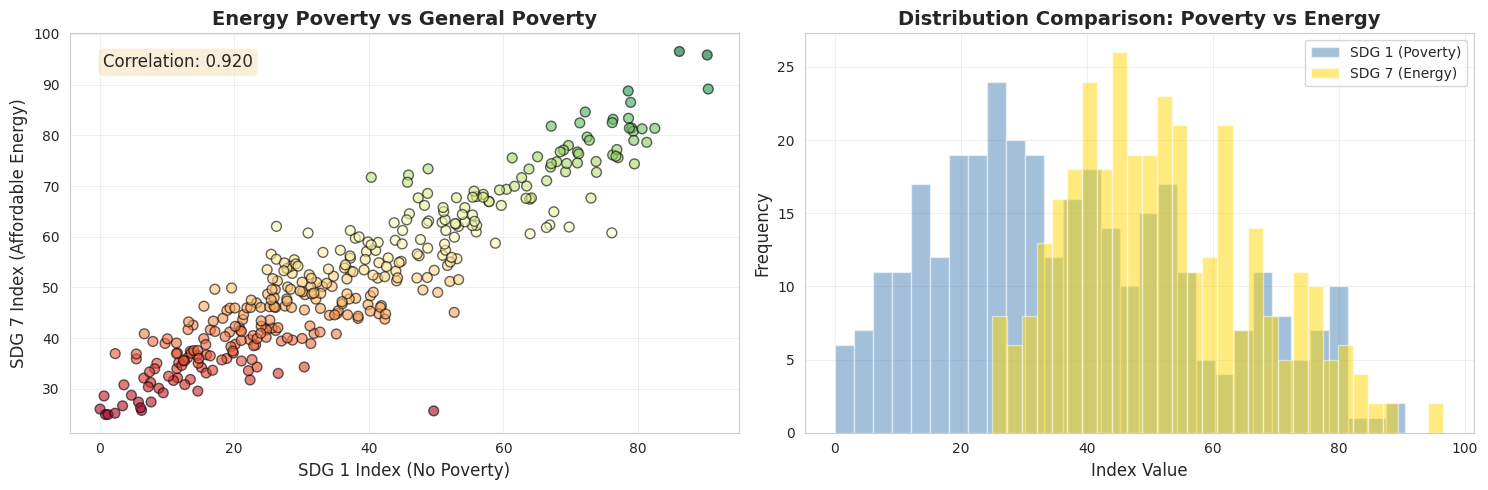

Correlation between SDG 1 and SDG 7: 0.9197


In [8]:
# Compare SDG 7 (Energy) with SDG 1 (Poverty)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(df_clean['index_sdg1'], df_clean['index_sdg7'],
                alpha=0.6, edgecolor='black', s=50, c=df_clean['index_sdg7'],
                cmap='RdYlGn')
axes[0].set_xlabel('SDG 1 Index (No Poverty)', fontsize=12)
axes[0].set_ylabel('SDG 7 Index (Affordable Energy)', fontsize=12)
axes[0].set_title('Energy Poverty vs General Poverty', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Calculate correlation
corr = df_clean[['index_sdg1', 'index_sdg7']].corr().iloc[0, 1]
axes[0].text(0.05, 0.95, f'Correlation: {corr:.3f}',
             transform=axes[0].transAxes, fontsize=12,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top')

# Distribution comparison
axes[1].hist(df_clean['index_sdg1'], bins=30, alpha=0.5, label='SDG 1 (Poverty)', color='steelblue')
axes[1].hist(df_clean['index_sdg7'], bins=30, alpha=0.5, label='SDG 7 (Energy)', color='gold')
axes[1].set_xlabel('Index Value', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution Comparison: Poverty vs Energy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correlation between SDG 1 and SDG 7: {corr:.4f}")

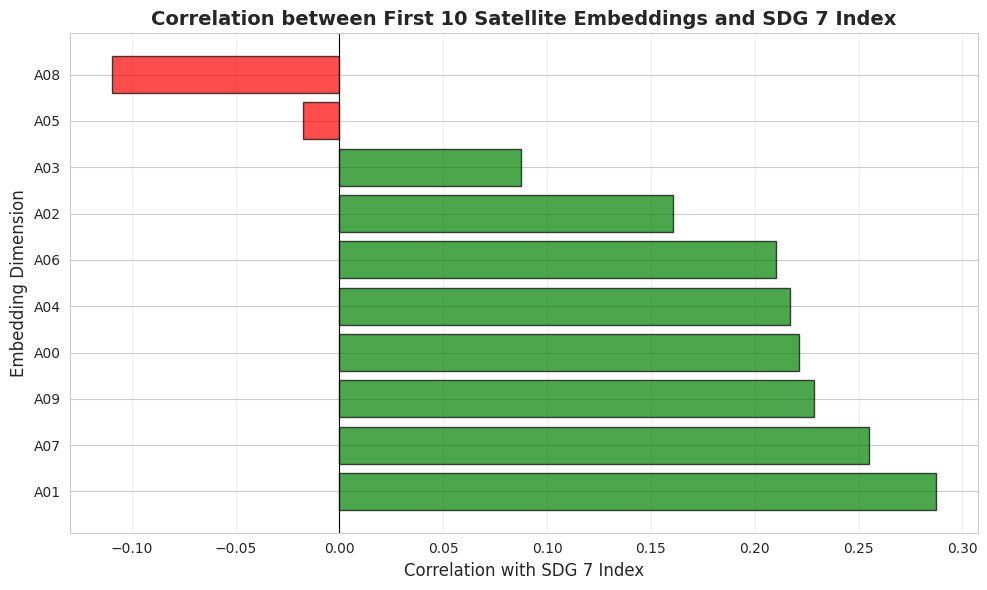

In [9]:
# Correlation between first 10 embeddings and SDG 7
corr_data = df_clean[['index_sdg7'] + embedding_cols[:10]].corr()['index_sdg7'][1:].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in corr_data.values]
plt.barh(corr_data.index, corr_data.values, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Correlation with SDG 7 Index', fontsize=12)
plt.ylabel('Embedding Dimension', fontsize=12)
plt.title('Correlation between First 10 Satellite Embeddings and SDG 7 Index', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 4. Model Training with Cross-Validation

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 271
Test set size: 68


In [11]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Model Configuration:")
print(f"  - n_estimators: {rf_model.n_estimators}")
print(f"  - max_depth: {rf_model.max_depth}")
print(f"  - min_samples_split: {rf_model.min_samples_split}")
print(f"  - min_samples_leaf: {rf_model.min_samples_leaf}")
print(f"  - max_features: {rf_model.max_features}")

Model Configuration:
  - n_estimators: 500
  - max_depth: 10
  - min_samples_split: 5
  - min_samples_leaf: 2
  - max_features: sqrt


In [12]:
# Perform 5-fold cross-validation on training set
print("\nPerforming 5-fold cross-validation...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_r2 = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='r2', n_jobs=-1)
cv_scores_mse = -cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
cv_scores_mae = -cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)

print("\n📊 Cross-Validation Results (5-Fold):")
print(f"  R² Score:  {cv_scores_r2.mean():.4f} (±{cv_scores_r2.std():.4f})")
print(f"  RMSE:      {np.sqrt(cv_scores_mse.mean()):.4f} (±{np.sqrt(cv_scores_mse.std()):.4f})")
print(f"  MAE:       {cv_scores_mae.mean():.4f} (±{cv_scores_mae.std():.4f})")


Performing 5-fold cross-validation...

📊 Cross-Validation Results (5-Fold):
  R² Score:  0.2482 (±0.0978)
  RMSE:      12.3100 (±4.8713)
  MAE:       9.9423 (±0.8330)


In [13]:
# Train final model on full training set
print("\nTraining final model on full training set...")
rf_model.fit(X_train, y_train)
print("✓ Model training complete!")


Training final model on full training set...
✓ Model training complete!


## 5. Model Evaluation

In [14]:
# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n🎯 Model Performance:")
print("\nTraining Set:")
print(f"  R² Score:  {train_r2:.4f}")
print(f"  RMSE:      {train_rmse:.4f}")
print(f"  MAE:       {train_mae:.4f}")

print("\nTest Set:")
print(f"  R² Score:  {test_r2:.4f}")
print(f"  RMSE:      {test_rmse:.4f}")
print(f"  MAE:       {test_mae:.4f}")

print(f"\nOverfitting Check:")
print(f"  R² Difference: {train_r2 - test_r2:.4f}")
if (train_r2 - test_r2) < 0.1:
    print("  ✓ Model shows good generalization")
else:
    print("  ⚠ Model may be overfitting")


🎯 Model Performance:

Training Set:
  R² Score:  0.8302
  RMSE:      5.9416
  MAE:       4.6561

Test Set:
  R² Score:  0.3507
  RMSE:      13.4261
  MAE:       10.0262

Overfitting Check:
  R² Difference: 0.4795
  ⚠ Model may be overfitting


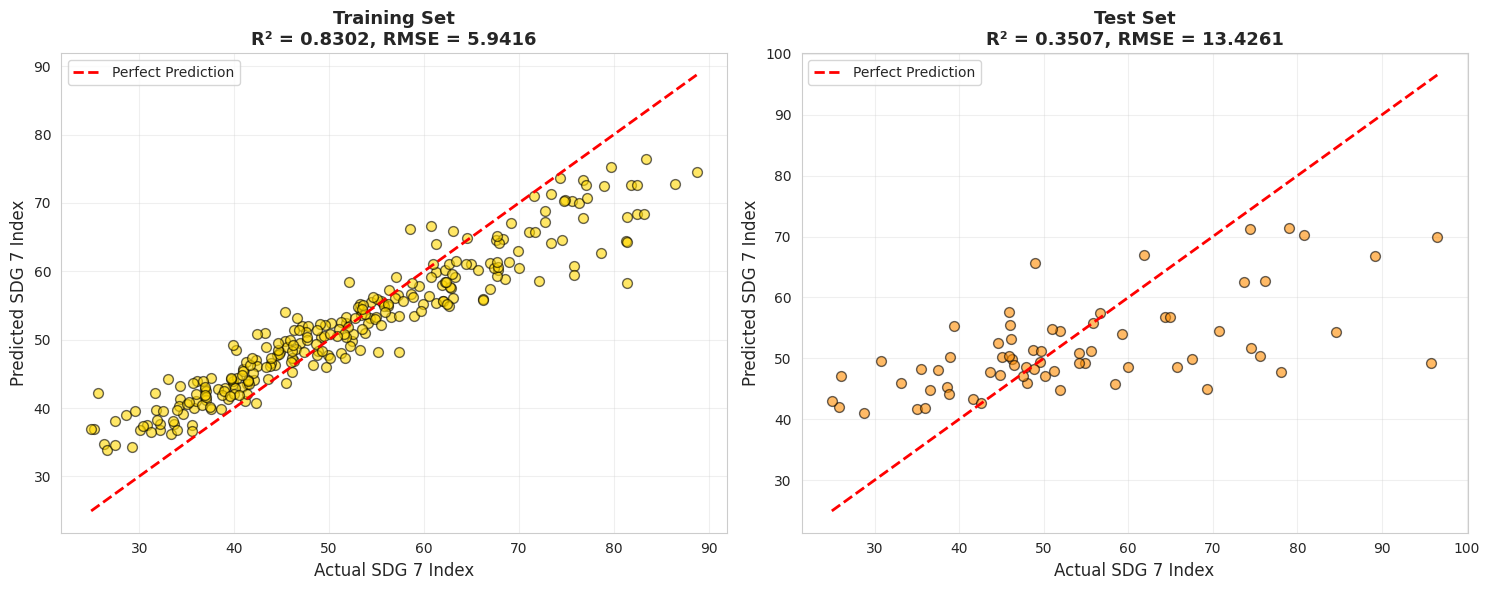

In [15]:
# Predicted vs Actual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.6, edgecolor='black', s=50, color='gold')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual SDG 7 Index', fontsize=12)
axes[0].set_ylabel('Predicted SDG 7 Index', fontsize=12)
axes[0].set_title(f'Training Set\nR² = {train_r2:.4f}, RMSE = {train_rmse:.4f}',
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, edgecolor='black', s=50, color='darkorange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual SDG 7 Index', fontsize=12)
axes[1].set_ylabel('Predicted SDG 7 Index', fontsize=12)
axes[1].set_title(f'Test Set\nR² = {test_r2:.4f}, RMSE = {test_rmse:.4f}',
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

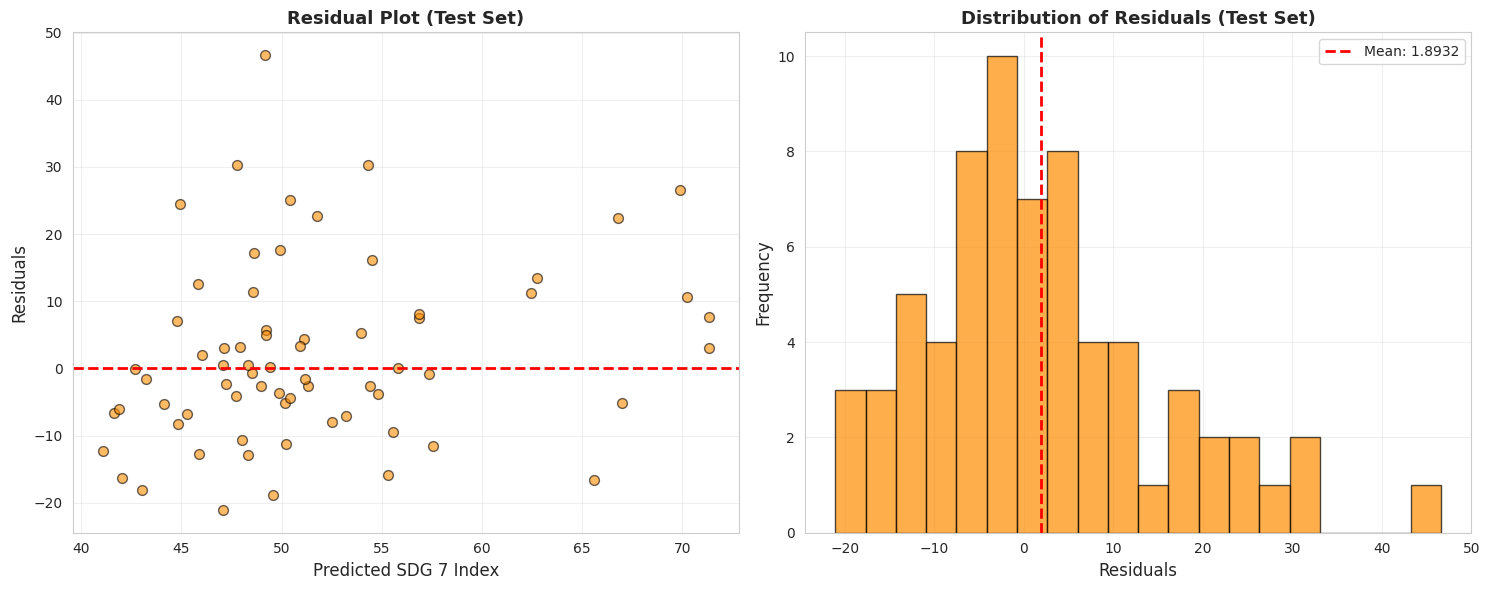

In [16]:
# Residual analysis
residuals_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Residuals vs Predicted
axes[0].scatter(y_test_pred, residuals_test, alpha=0.6, edgecolor='black', s=50, color='darkorange')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted SDG 7 Index', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residual Plot (Test Set)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Residuals distribution
axes[1].hist(residuals_test, bins=20, edgecolor='black', alpha=0.7, color='darkorange')
axes[1].axvline(residuals_test.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {residuals_test.mean():.4f}')
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals (Test Set)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

In [17]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': embedding_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🌟 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))


🌟 Top 20 Most Important Features:
feature  importance
    A13    0.046715
    A57    0.042766
    A59    0.042742
    A21    0.030991
    A52    0.024661
    A43    0.024177
    A30    0.022629
    A01    0.021050
    A06    0.020633
    A26    0.020309
    A49    0.019593
    A39    0.018093
    A60    0.017701
    A37    0.017464
    A04    0.017189
    A07    0.016870
    A58    0.016808
    A17    0.016445
    A48    0.016262
    A33    0.015612


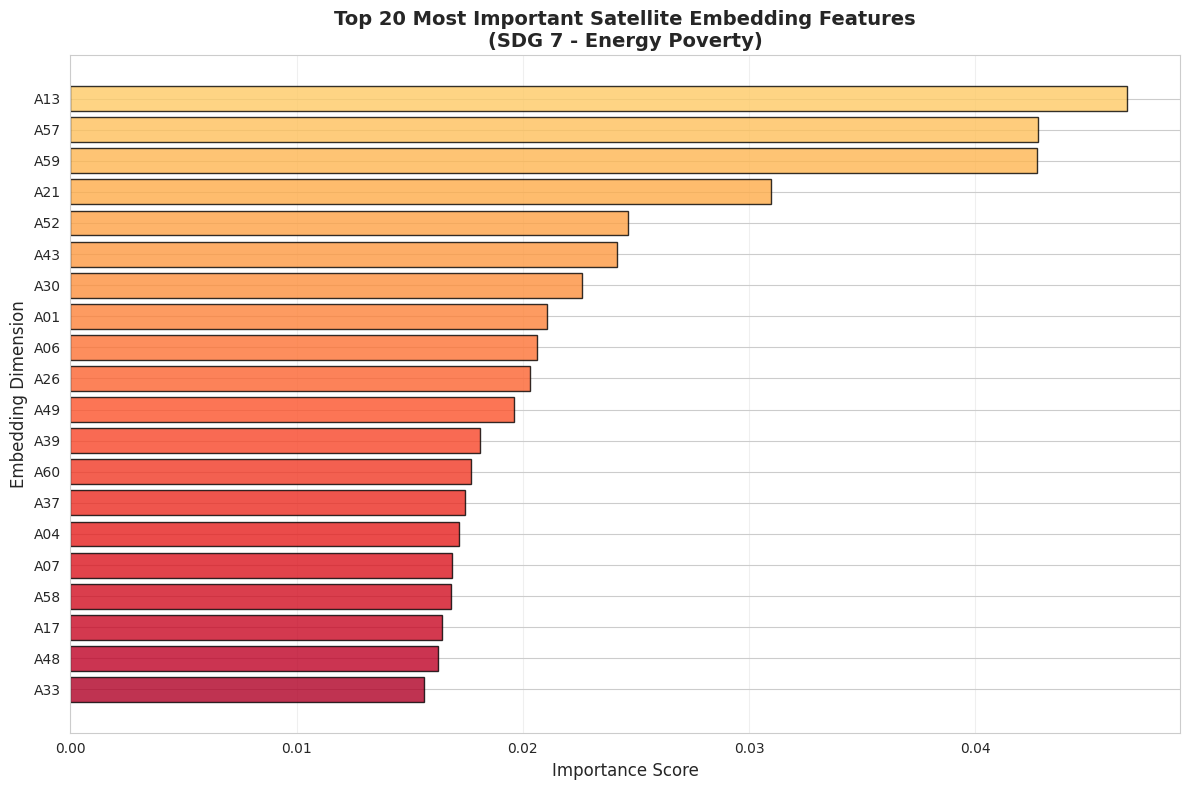

In [18]:
# Visualize top 20 features
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, top_n))
plt.barh(range(top_n), top_features['importance'].values, color=colors, edgecolor='black', alpha=0.8)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Embedding Dimension', fontsize=12)
plt.title(f'Top {top_n} Most Important Satellite Embedding Features\n(SDG 7 - Energy Poverty)',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


📊 Cumulative Importance Analysis:
  Features needed for 80% importance: 45 (70.3%)
  Features needed for 95% importance: 59 (92.2%)


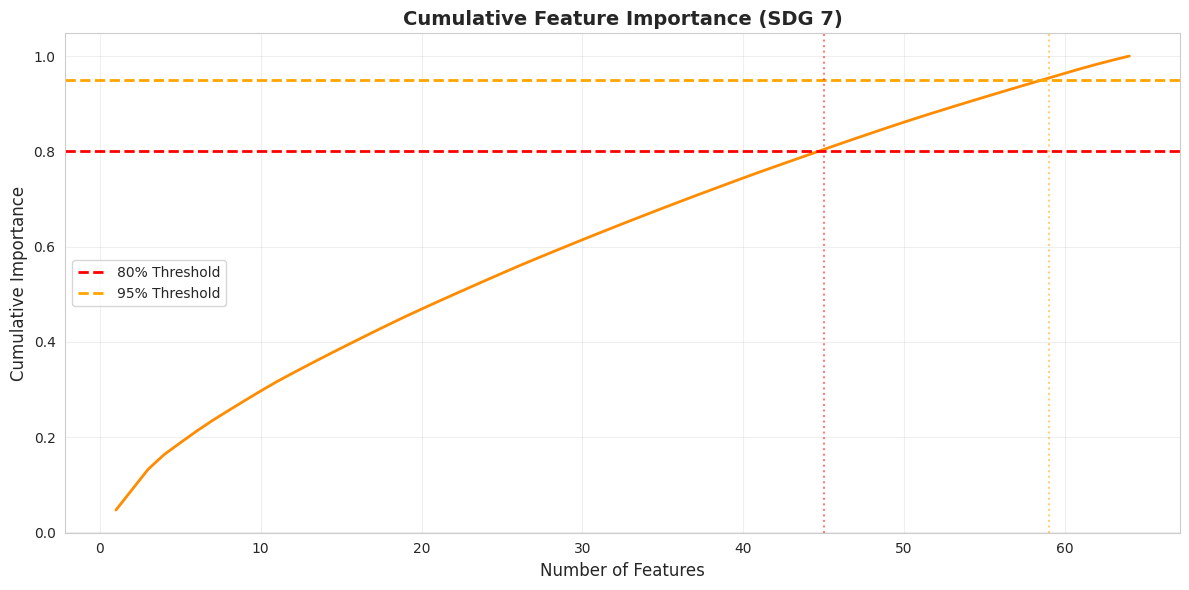

In [19]:
# Cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

# Find number of features needed for 80% and 95% importance
n_features_80 = (feature_importance['cumulative_importance'] <= 0.80).sum() + 1
n_features_95 = (feature_importance['cumulative_importance'] <= 0.95).sum() + 1

print(f"\n📊 Cumulative Importance Analysis:")
print(f"  Features needed for 80% importance: {n_features_80} ({n_features_80/len(embedding_cols)*100:.1f}%)")
print(f"  Features needed for 95% importance: {n_features_95} ({n_features_95/len(embedding_cols)*100:.1f}%)")

# Plot cumulative importance
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(feature_importance) + 1),
         feature_importance['cumulative_importance'].values,
         linewidth=2, color='darkorange')
plt.axhline(y=0.80, color='red', linestyle='--', linewidth=2, label='80% Threshold')
plt.axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95% Threshold')
plt.axvline(x=n_features_80, color='red', linestyle=':', alpha=0.5)
plt.axvline(x=n_features_95, color='orange', linestyle=':', alpha=0.5)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.title('Cumulative Feature Importance (SDG 7)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

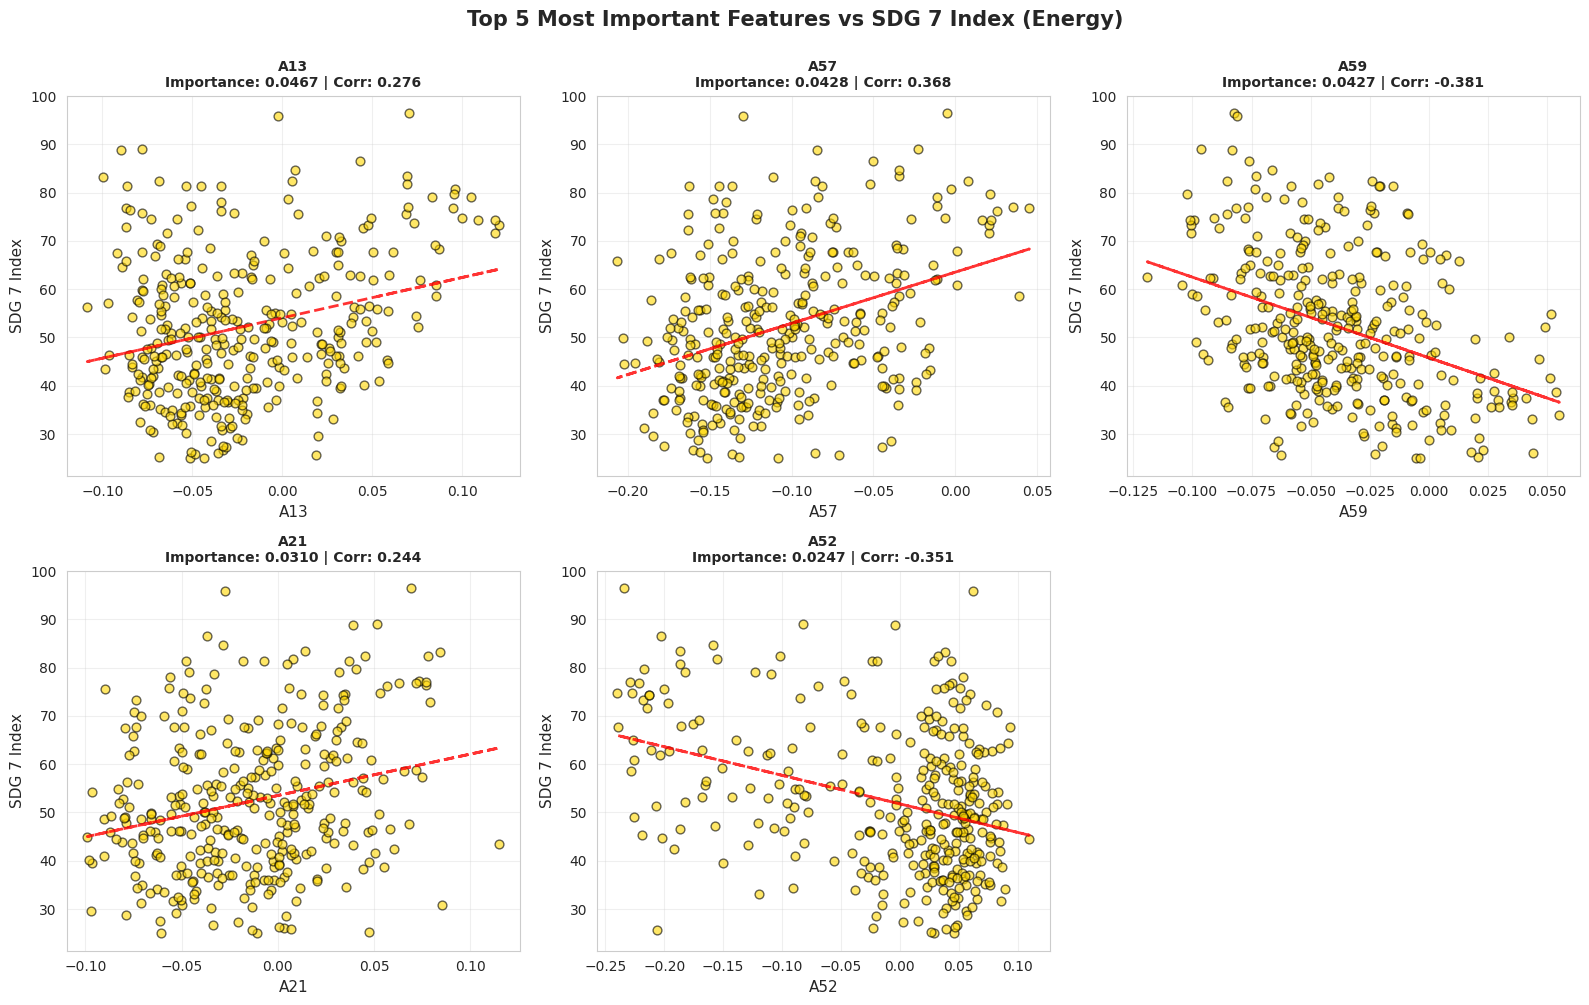

In [20]:
# Analyze relationship between top features and target
top_5_features = feature_importance.head(5)['feature'].values

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_5_features):
    ax = axes[idx]
    ax.scatter(df_clean[feature], df_clean['index_sdg7'], alpha=0.6, edgecolor='black', s=40, color='gold')

    # Add trend line
    z = np.polyfit(df_clean[feature], df_clean['index_sdg7'], 1)
    p = np.poly1d(z)
    ax.plot(df_clean[feature], p(df_clean[feature]), "r--", linewidth=2, alpha=0.8)

    # Calculate correlation
    corr = df_clean[[feature, 'index_sdg7']].corr().iloc[0, 1]

    ax.set_xlabel(f'{feature}', fontsize=11)
    ax.set_ylabel('SDG 7 Index', fontsize=11)
    ax.set_title(f'{feature}\nImportance: {feature_importance[feature_importance["feature"]==feature]["importance"].values[0]:.4f} | Corr: {corr:.3f}',
                 fontsize=10, fontweight='bold')
    ax.grid(alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('Top 5 Most Important Features vs SDG 7 Index (Energy)', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 7. Spatial Visualization of Predictions

In [21]:
# Predict for all municipalities
y_pred_all = rf_model.predict(X)

# Create results dataframe
results_df = df_clean[['asdf_id', 'mun', 'dep', 'index_sdg7']].copy()
results_df['predicted_sdg7'] = y_pred_all
results_df['residual'] = results_df['index_sdg7'] - results_df['predicted_sdg7']
results_df['abs_error'] = np.abs(results_df['residual'])

print("\n📍 Municipalities with Largest Prediction Errors:")
print("\nTop 10 Overpredictions (Model predicts higher than actual):")
print(results_df.nlargest(10, 'residual')[['mun', 'dep', 'index_sdg7', 'predicted_sdg7', 'residual']].to_string(index=False))

print("\nTop 10 Underpredictions (Model predicts lower than actual):")
print(results_df.nsmallest(10, 'residual')[['mun', 'dep', 'index_sdg7', 'predicted_sdg7', 'residual']].to_string(index=False))


📍 Municipalities with Largest Prediction Errors:

Top 10 Overpredictions (Model predicts higher than actual):
                    mun        dep  index_sdg7  predicted_sdg7  residual
                 La Paz     La Paz   95.830002       49.187856 46.642146
               Trinidad       Beni   84.599998       54.319157 30.280841
            Huachacalla      Oruro   78.000000       47.773106 30.226894
Santa Cruz de la Sierra Santa Cruz   96.529999       69.896791 26.633208
                 Atocha     Potosí   75.550003       50.420082 25.129921
              Llallagua     Potosí   69.360001       44.913899 24.446102
                  Sucre Chuquisaca   81.419998       58.334683 23.085315
                  Vinto Cochabamba   74.449997       51.748640 22.701357
            Colcapirhua Cochabamba   89.129997       66.794839 22.335158
                 Tupiza     Potosí   67.580002       49.911270 17.668732

Top 10 Underpredictions (Model predicts lower than actual):
                   mun   

In [22]:
# Load spatial data for mapping
try:
    import geopandas as gpd

    geojson_url = f"{REPO_URL}/maps/bolivia339geoqueryOpt.geojson"
    print("Loading GeoJSON map...")
    gdf = gpd.read_file(geojson_url)
    gdf['asdf_id'] = gdf['asdf_id'].astype(int)

    # Merge with predictions
    gdf_results = gdf.merge(results_df, on='asdf_id', how='inner')

    print(f"✓ Loaded spatial data for {len(gdf_results)} municipalities")

except ImportError:
    print("⚠ GeoPandas not available. Skipping spatial visualization.")
    print("  Install with: !pip install geopandas")
    gdf_results = None

Loading GeoJSON map...
✓ Loaded spatial data for 339 municipalities


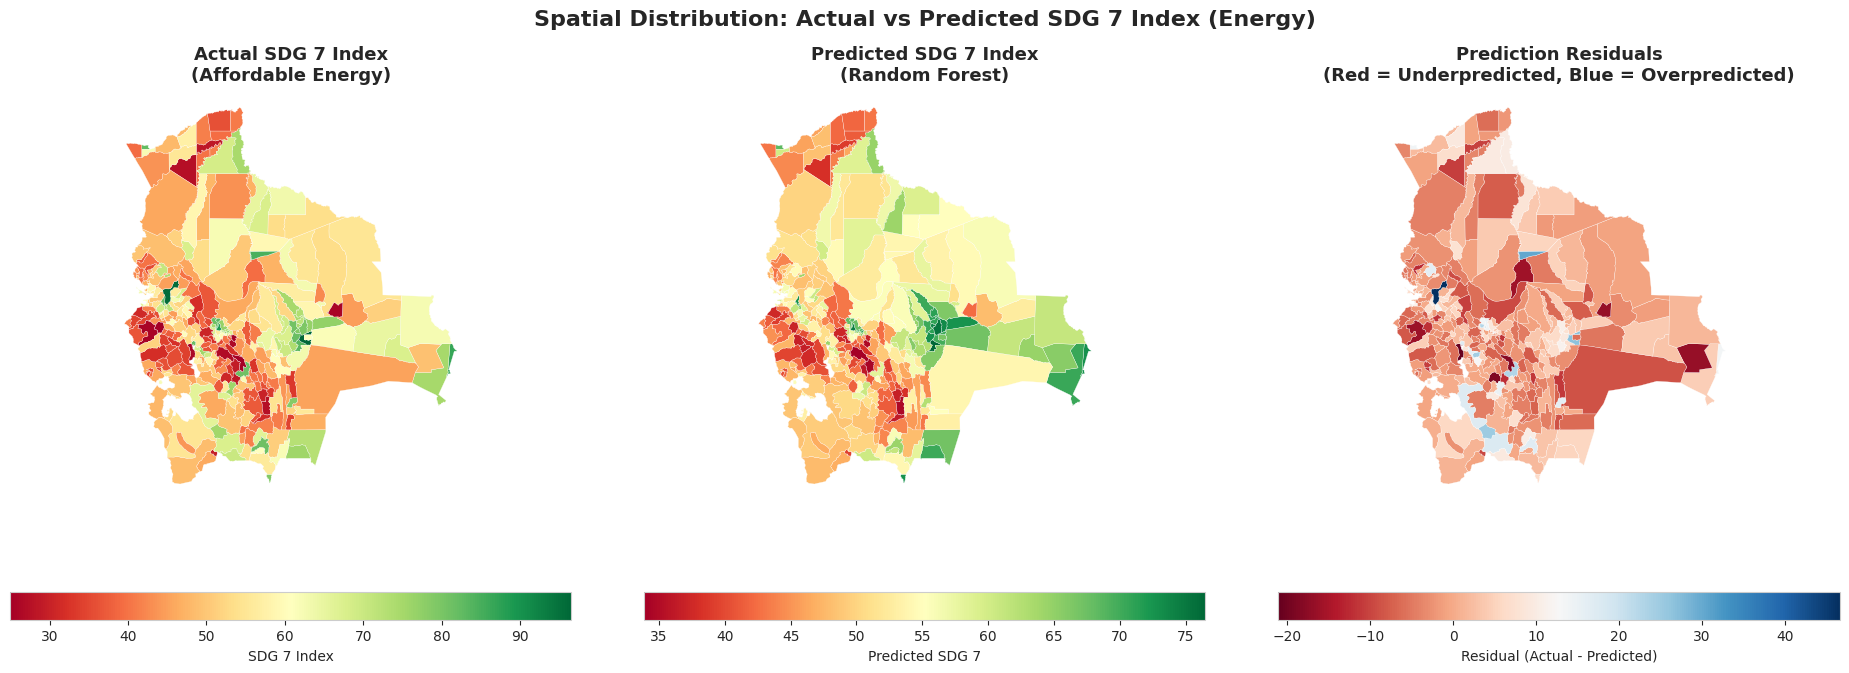

In [23]:
# Create spatial comparison maps
if gdf_results is not None:
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Actual SDG 7
    gdf_results.plot(column='index_sdg7', cmap='RdYlGn', linewidth=0.2,
                     edgecolor='white', legend=True, ax=axes[0],
                     legend_kwds={'label': 'SDG 7 Index', 'orientation': 'horizontal', 'shrink': 0.8})
    axes[0].set_title('Actual SDG 7 Index\n(Affordable Energy)', fontsize=13, fontweight='bold')
    axes[0].set_axis_off()

    # Predicted SDG 7
    gdf_results.plot(column='predicted_sdg7', cmap='RdYlGn', linewidth=0.2,
                     edgecolor='white', legend=True, ax=axes[1],
                     legend_kwds={'label': 'Predicted SDG 7', 'orientation': 'horizontal', 'shrink': 0.8})
    axes[1].set_title('Predicted SDG 7 Index\n(Random Forest)', fontsize=13, fontweight='bold')
    axes[1].set_axis_off()

    # Residuals
    gdf_results.plot(column='residual', cmap='RdBu', linewidth=0.2,
                     edgecolor='white', legend=True, ax=axes[2],
                     legend_kwds={'label': 'Residual (Actual - Predicted)', 'orientation': 'horizontal', 'shrink': 0.8})
    axes[2].set_title('Prediction Residuals\n(Red = Underpredicted, Blue = Overpredicted)',
                      fontsize=13, fontweight='bold')
    axes[2].set_axis_off()

    plt.suptitle('Spatial Distribution: Actual vs Predicted SDG 7 Index (Energy)',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
else:
    print("Spatial visualization skipped (GeoPandas not available)")

## 8. Summary and Insights

In [24]:
print("\n" + "="*80)
print("MODEL SUMMARY: Random Forest for SDG 7 Energy Poverty Prediction")
print("="*80)

print("\n📊 PERFORMANCE METRICS:")
print(f"  Cross-Validation R² (5-fold): {cv_scores_r2.mean():.4f} (±{cv_scores_r2.std():.4f})")
print(f"  Test Set R²:                  {test_r2:.4f}")
print(f"  Test Set RMSE:                {test_rmse:.4f}")
print(f"  Test Set MAE:                 {test_mae:.4f}")

print("\n🌟 FEATURE IMPORTANCE:")
print(f"  Total embedding dimensions:   {len(embedding_cols)}")
print(f"  Features for 80% importance:  {n_features_80} ({n_features_80/len(embedding_cols)*100:.1f}%)")
print(f"  Features for 95% importance:  {n_features_95} ({n_features_95/len(embedding_cols)*100:.1f}%)")
print(f"\n  Top 5 Features: {', '.join(top_5_features)}")

print("\n🎯 KEY INSIGHTS:")
if test_r2 > 0.7:
    print("  ✓ Strong predictive power: Satellite embeddings capture energy poverty patterns well")
elif test_r2 > 0.5:
    print("  ✓ Moderate predictive power: Satellite embeddings provide useful energy poverty signals")
else:
    print("  ⚠ Limited predictive power: Additional features may be needed")

if (train_r2 - test_r2) < 0.1:
    print("  ✓ Good generalization: Model performs consistently on unseen data")
else:
    print("  ⚠ Potential overfitting: Consider regularization or ensemble approaches")

print("\n💡 RECOMMENDATIONS:")
print("  1. Energy poverty shows different spatial patterns than general poverty")
print("  2. Night-time lights data could significantly improve energy access predictions")
print("  3. Consider urbanization metrics and grid connectivity data as additional features")
print("  4. Investigate municipalities with large errors for infrastructure gaps")
print("  5. Multi-temporal analysis could reveal electrification trends")

print("\n" + "="*80)


MODEL SUMMARY: Random Forest for SDG 7 Energy Poverty Prediction

📊 PERFORMANCE METRICS:
  Cross-Validation R² (5-fold): 0.2482 (±0.0978)
  Test Set R²:                  0.3507
  Test Set RMSE:                13.4261
  Test Set MAE:                 10.0262

🌟 FEATURE IMPORTANCE:
  Total embedding dimensions:   64
  Features for 80% importance:  45 (70.3%)
  Features for 95% importance:  59 (92.2%)

  Top 5 Features: A13, A57, A59, A21, A52

🎯 KEY INSIGHTS:
  ⚠ Limited predictive power: Additional features may be needed
  ⚠ Potential overfitting: Consider regularization or ensemble approaches

💡 RECOMMENDATIONS:
  1. Energy poverty shows different spatial patterns than general poverty
  2. Night-time lights data could significantly improve energy access predictions
  3. Consider urbanization metrics and grid connectivity data as additional features
  4. Investigate municipalities with large errors for infrastructure gaps
  5. Multi-temporal analysis could reveal electrification trends


## 9. Export Results (Optional)

In [25]:
# Uncomment to save results
# results_df.to_csv('sdg7_predictions_rf.csv', index=False)
# feature_importance.to_csv('feature_importance_sdg7_rf.csv', index=False)
# print("✓ Results exported successfully")

---

## Conclusion

This notebook demonstrated how to:
1. ✅ Predict energy poverty (SDG 7) using satellite embeddings
2. ✅ Compare energy poverty patterns with general poverty (SDG 1)
3. ✅ Identify key satellite features for energy access prediction
4. ✅ Evaluate model performance and identify prediction errors
5. ✅ Visualize spatial patterns of energy poverty across Bolivia

### Key Findings
- Energy poverty (SDG 7) shows distinct patterns from general poverty (SDG 1)
- Satellite imagery captures geographic and infrastructural features related to energy access
- Night-time lights would be a natural complement to these predictions

### Next Steps
- Incorporate night-time lights (NTL) data for direct energy usage proxy
- Combine with population density and urbanization metrics
- Perform temporal analysis to track electrification progress
- Compare with SDG 9 (Industry & Infrastructure) patterns

### Citation
If you use this analysis, please cite:

Mendez, C., Gonzales, E., Leoni, P., Andersen, L., Peralta, H. (2026). DS4Bolivia: A Data Science Repository to Study GeoSpatial Development in Bolivia [Data set]. GitHub. https://github.com/quarcs-lab/ds4bolivia